# Prétraitement des données pour la prédiction des prix immobiliers

Ce notebook détaille les étapes de prétraitement des données pour le projet de prédiction des prix immobiliers (dataset House Prices). Il inclut l'exploration, le feature engineering, la gestion des valeurs manquantes, la détection des outliers, l'encodage, la standardisation, et la sauvegarde des données traitées.

## Objectifs
- Préparer les données pour un modèle de machine learning.
- Créer des features pertinentes pour améliorer la prédiction.
- Documenter chaque étape pour une reproductibilité facile.

## Structure
1. **Configuration initiale** : Importation des bibliothèques et configuration de base.
2. **Chargement des données** : Lecture des fichiers `train.csv` et `test.csv`.
3. **Exploration des données** : Analyse des types et des valeurs manquantes.
4. **Feature Engineering** : Création de nouvelles features.
5. **Sélection des features** : Utilisation de corrélations et PPS.
6. **Gestion des valeurs manquantes** : Imputation.
7. **Gestion des outliers** : Détection et correction.
8. **Encodage et standardisation** : Préparation pour la modélisation.
9. **Sauvegarde** : Exportation des données traitées.

In [3]:
import sys
import pathlib

# Ajouter le dossier racine du projet (celui qui contient src/) au PYTHONPATH
root_path = pathlib.Path().resolve().parent  # remonte d’un dossier depuis notebooks/
sys.path.append(str(root_path))

##### Télécharger le dataset depuis kaggle

In [ ]:
# from src.data.make_dataset import download_kaggle_data
# download_kaggle_data()

In [22]:
# Configuration initiale
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
import ppscore as pps
import logging
from IPython.display import display
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
import joblib

# Configuration du logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s - %(levelname)s - %(message)s")
logger = logging.getLogger(__name__)

# Configuration des graphiques
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Définir le chemin absolu du projet
PROJECT_DIR = Path(
    "./../"
)
# Chargement des données
DATA_DIR = PROJECT_DIR / "data"
PROCESSED_DIR = DATA_DIR / "processed"
sys.path = [str(PROJECT_DIR)] + [p for p in sys.path if p != str(PROJECT_DIR)]

# Constantes
TARGET_NAME = "SalePrice"
SEED = 42
MIN_CORR_COEF = 0.15
MIN_PPS = 0.1
MISSING_THRESHOLD = 35.0

logger.info("Bibliothèques importées et configuration terminée.")

2025-07-30 21:57:00,495 - INFO - Bibliothèques importées et configuration terminée.


In [23]:
from src.data_processing import (
   create_features,
   impute_missing_values,
    remove_outliers,
    preprocess_data,
)

## Étape 2 : Chargement des données

Cette étape charge les fichiers `train.csv` et `test.csv` à partir du répertoire `data/raw/`, supprime la colonne `Id` non pertinente, et affiche un aperçu des données.

In [24]:
train_df = pd.read_csv(DATA_DIR / "raw/train.csv").drop("Id", axis=1)
test_df = pd.read_csv(DATA_DIR / "raw/test.csv").drop("Id", axis=1)
test_ids = pd.read_csv(DATA_DIR / "raw/test.csv")["Id"]

# Affichage des dimensions et aperçu
logger.info(f"Dimensions de train_df : {train_df.shape}")
logger.info(f"Dimensions de test_df : {test_df.shape}")
display(train_df.head())
display(test_df.head())

2025-07-30 21:57:05,786 - INFO - Dimensions de train_df : (1460, 80)
2025-07-30 21:57:05,791 - INFO - Dimensions de test_df : (1459, 79)


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


## Étape 3 : Exploration des données

Objectif : Identifier les types de données (numériques, catégoriques) pour planifier le prétraitement.

### Actions
- Lister les colonnes numériques et catégoriques.
- Afficher un résumé avec `info()`.
- Visualiser la répartition des types via un barplot.

In [25]:
# Identification des colonnes par type
numeric_cols = train_df.select_dtypes(include=["int64", "float64"]).columns
categorical_cols = train_df.select_dtypes(include=["object"]).columns

logger.info(f"Colonnes numériques ({len(numeric_cols)}): {list(numeric_cols)}\n\n")
logger.info(f"Colonnes catégoriques ({len(categorical_cols)}): {list(categorical_cols)}")

2025-07-30 21:57:09,434 - INFO - Colonnes numériques (37): ['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


2025-07-30 21:57:09,434 - INFO - Colonnes catégoriques (43): ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'Hea

In [26]:
# Résumé des types
logger.info("Résumé des types de données :")
train_df.info()

2025-07-30 21:57:11,908 - INFO - Résumé des types de données :


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 80 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   MSSubClass     1460 non-null   int64  
 1   MSZoning       1460 non-null   object 
 2   LotFrontage    1201 non-null   float64
 3   LotArea        1460 non-null   int64  
 4   Street         1460 non-null   object 
 5   Alley          91 non-null     object 
 6   LotShape       1460 non-null   object 
 7   LandContour    1460 non-null   object 
 8   Utilities      1460 non-null   object 
 9   LotConfig      1460 non-null   object 
 10  LandSlope      1460 non-null   object 
 11  Neighborhood   1460 non-null   object 
 12  Condition1     1460 non-null   object 
 13  Condition2     1460 non-null   object 
 14  BldgType       1460 non-null   object 
 15  HouseStyle     1460 non-null   object 
 16  OverallQual    1460 non-null   int64  
 17  OverallCond    1460 non-null   int64  
 18  YearBuil

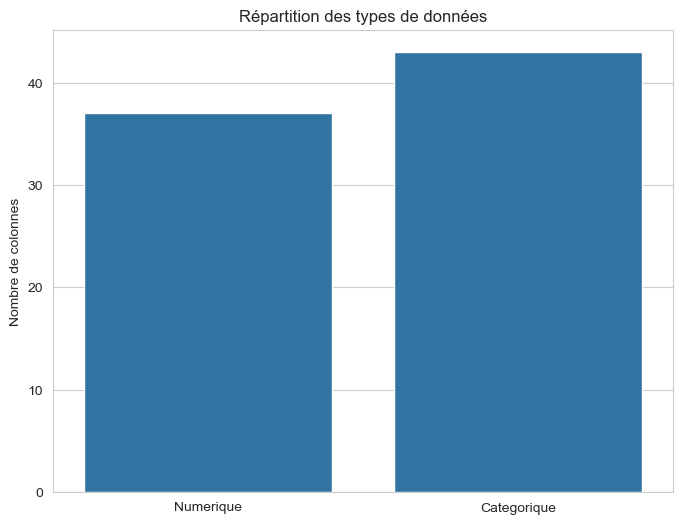

In [27]:
# Vérification des variables
if "numeric_cols" not in locals() or "categorical_cols" not in locals():
    raise ValueError("Les variables numeric_cols et categorical_cols doivent être définies avant cette visualisation.")

# Création du dictionnaire des comptages
type_counts = {"Numerique": len(numeric_cols), "Categorique": len(categorical_cols)}

# Visualisation de la répartition des types
plt.figure(figsize=(8, 6))
sns.barplot(x=list(type_counts.keys()), y=list(type_counts.values()))  # Ajout explicite des parenthèses
plt.title("Répartition des types de données")
plt.ylabel("Nombre de colonnes")
plt.show()

## Étape 4 : Analyse des valeurs manquantes

Objectif : Identifier les colonnes avec des valeurs manquantes pour planifier leur gestion.

### Actions
- Calculer le pourcentage de valeurs manquantes.
- Afficher les colonnes avec des valeurs manquantes (>0%).
- Visualiser via un barplot.

In [28]:
# Calcul du pourcentage de valeurs manquantes
missing_values = train_df.isnull().mean() * 100
missing_values = missing_values[missing_values > 0].sort_values(ascending=False)

logger.info("Pourcentage de valeurs manquantes par colonne :")
display(missing_values)

2025-07-30 21:57:17,895 - INFO - Pourcentage de valeurs manquantes par colonne :


PoolQC          99.520548
MiscFeature     96.301370
Alley           93.767123
Fence           80.753425
FireplaceQu     47.260274
LotFrontage     17.739726
GarageType       5.547945
GarageYrBlt      5.547945
GarageFinish     5.547945
GarageQual       5.547945
GarageCond       5.547945
BsmtExposure     2.602740
BsmtFinType2     2.602740
BsmtFinType1     2.534247
BsmtCond         2.534247
BsmtQual         2.534247
MasVnrArea       0.547945
MasVnrType       0.547945
Electrical       0.068493
dtype: float64

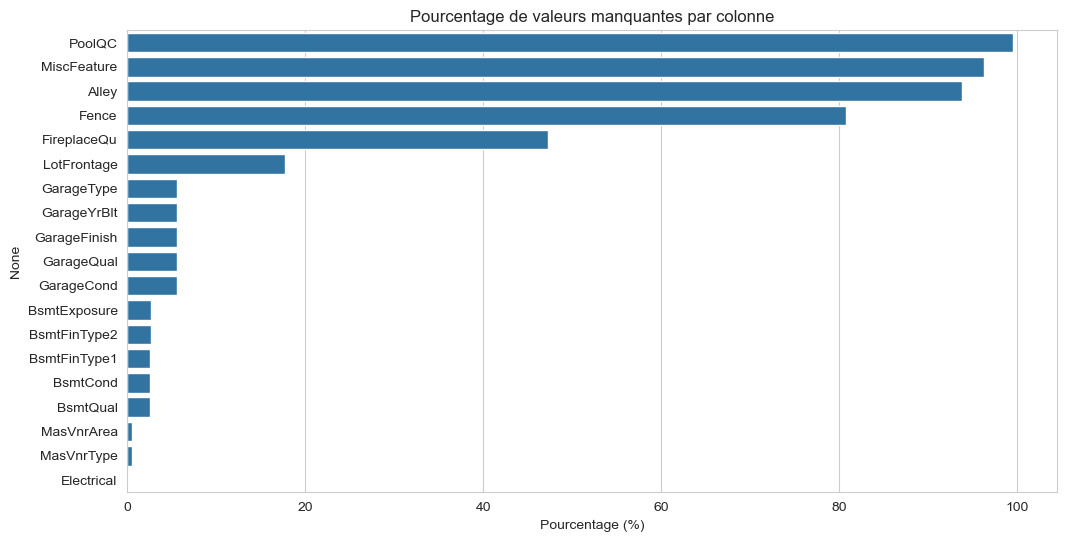

In [29]:
# Visualisation via un barplot
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.values, y=missing_values.index)
plt.title("Pourcentage de valeurs manquantes par colonne")
plt.xlabel("Pourcentage (%)")
plt.show()

## Étape 5 : Feature Engineering

Objectif : Créer de nouvelles features pour améliorer la prédiction et visualiser leurs relations avec `sale_price`.

### Nouvelles features
- **building_age**: `YrSold - YearBuilt` 
- **remodel_age**: `YrSold - YearRemodAdd` 
- **garage_age**: `YrSold - GarageYrBlt` 
- **total_sf**: `1stFlrSF + 2ndFlrSF + TotalBsmtSF` 
- **total_bathrooms**: `FullBath + 0.5 * HalfBath + BsmtFullBath + 0.5 * BsmtHalfBath` 

### Actions
- Créer les features avec la fonction `create_features`.
- Visualiser la distribution de `sale_price` et les relations avec les nouvelles features.

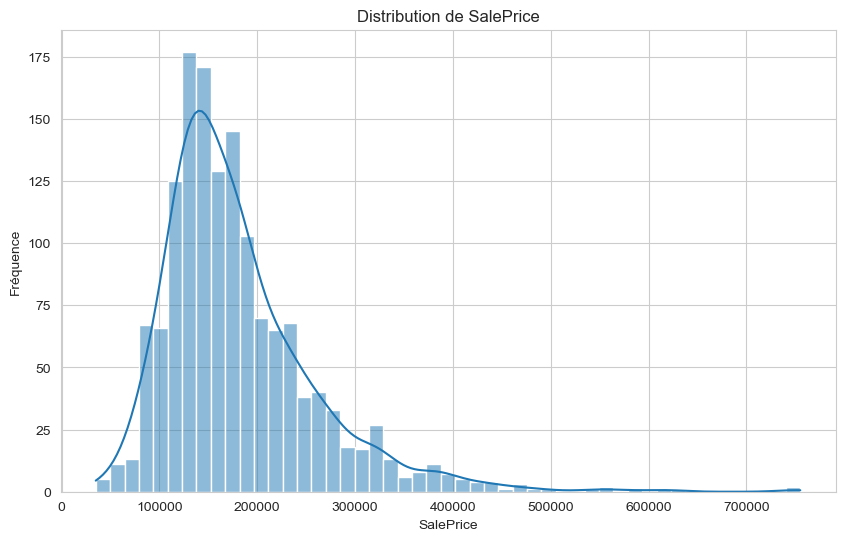

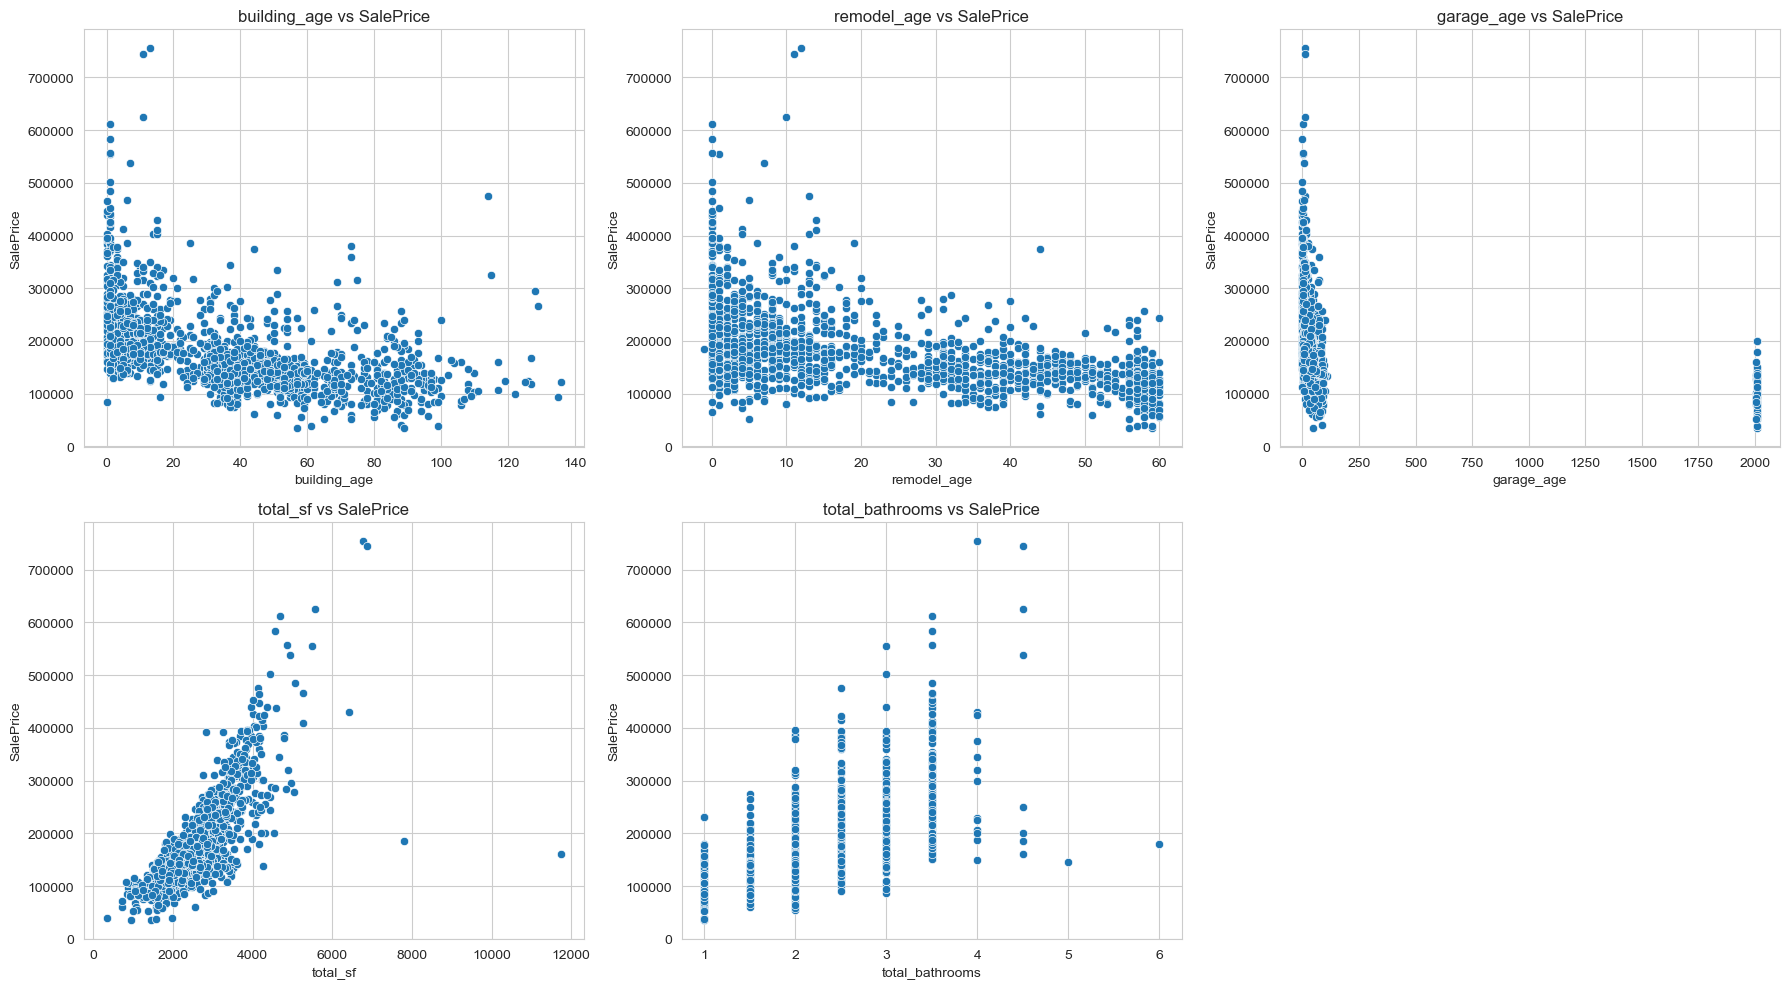

In [30]:
# Création des features
train_df = create_features(train_df)
test_df = create_features(test_df)

# Visualisation de la distribution de SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(train_df["SalePrice"], kde=True)
plt.title("Distribution de SalePrice")
plt.xlabel("SalePrice")
plt.ylabel("Fréquence")
plt.show()

# Scatter plots pour les nouvelles features vs SalePrice
new_features = ["building_age", "remodel_age", "garage_age", "total_sf", "total_bathrooms"]
fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, feature in enumerate(new_features):
    sns.scatterplot(x=train_df[feature], y=train_df["SalePrice"], ax=axes[i])
    axes[i].set_title(f"{feature} vs SalePrice")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("SalePrice")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

In [31]:
numeric_cols = [
    col for col in train_df.select_dtypes(include=["int64", "float64"]).columns 
    if col not in ["SalePrice"]
]

## Étape 6 : Sélection des features

Objectif : Sélectionner les features les plus pertinentes avec la corrélation et le Predictive Power Score (PPS).

### Actions
- Calculer la matrice de corrélation.
- Appliquer un seuil de corrélation.
- Calculer le PPS et appliquer un seuil.
- Combiner les features sélectionnées.
- Supprimer les features avec plus de 35% de valeurs manquantes.

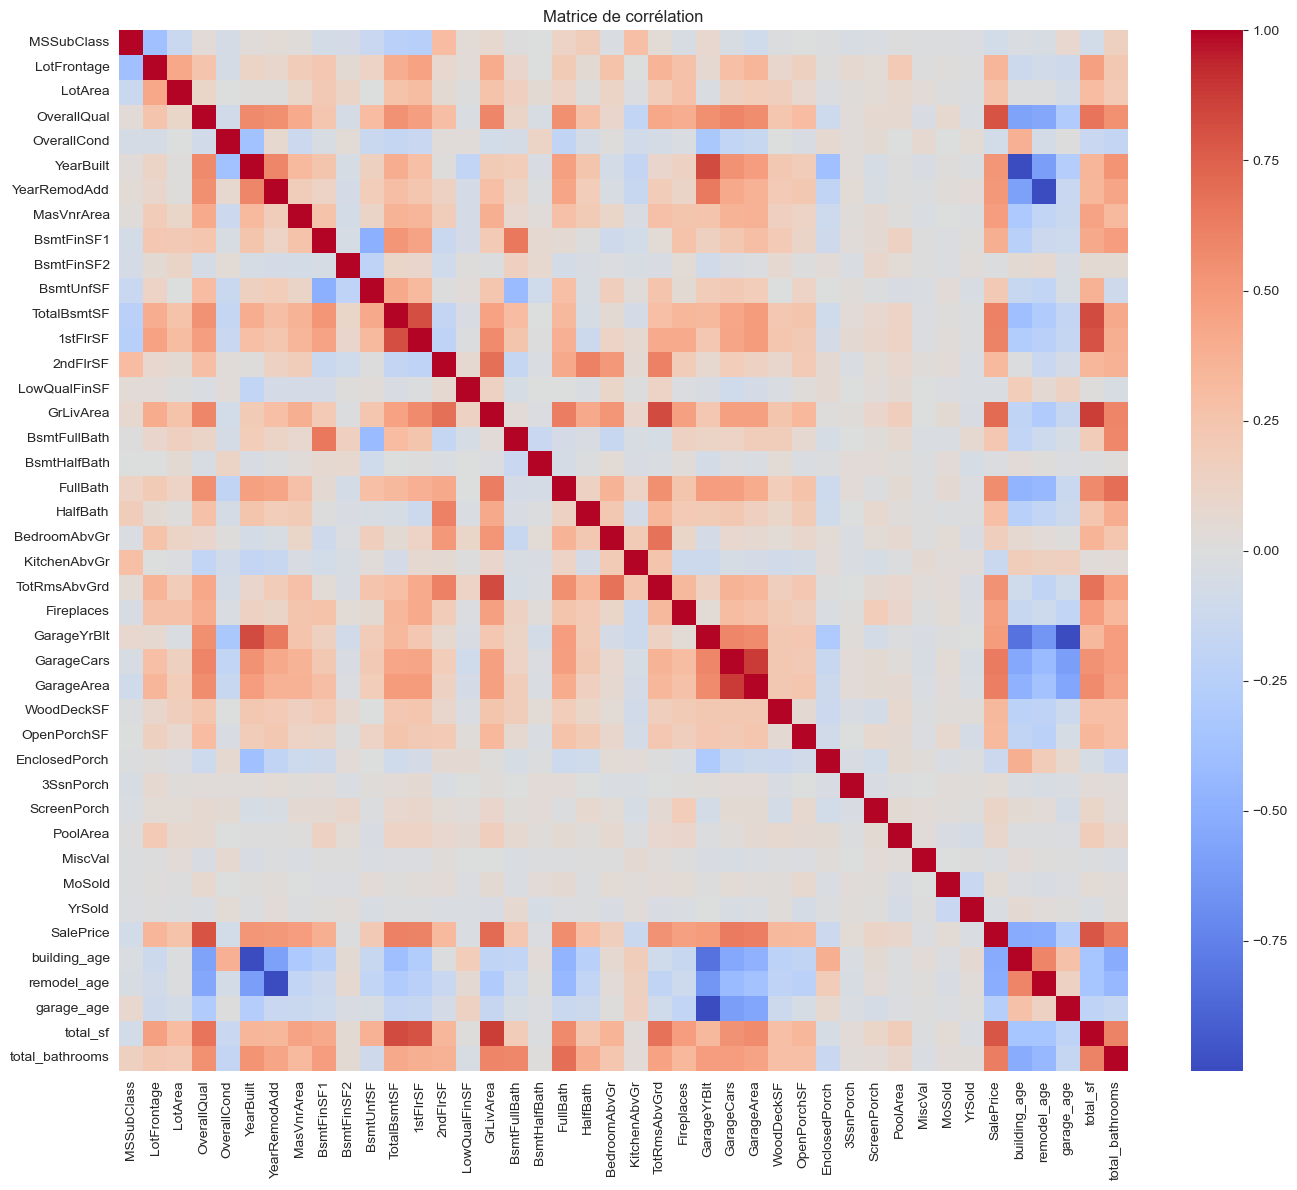

2025-07-30 21:57:45,241 - INFO - Corrélations avec SalePrice:


SalePrice          1.000000
OverallQual        0.790982
total_sf           0.782260
GrLivArea          0.708624
GarageCars         0.640409
total_bathrooms    0.631731
GarageArea         0.623431
TotalBsmtSF        0.613581
1stFlrSF           0.605852
FullBath           0.560664
TotRmsAbvGrd       0.533723
YearBuilt          0.522897
YearRemodAdd       0.507101
GarageYrBlt        0.486362
MasVnrArea         0.477493
Fireplaces         0.466929
BsmtFinSF1         0.386420
LotFrontage        0.351799
WoodDeckSF         0.324413
2ndFlrSF           0.319334
OpenPorchSF        0.315856
HalfBath           0.284108
LotArea            0.263843
BsmtFullBath       0.227122
BsmtUnfSF          0.214479
BedroomAbvGr       0.168213
ScreenPorch        0.111447
PoolArea           0.092404
MoSold             0.046432
3SsnPorch          0.044584
BsmtFinSF2        -0.011378
BsmtHalfBath      -0.016844
MiscVal           -0.021190
LowQualFinSF      -0.025606
YrSold            -0.028923
OverallCond       -0

2025-07-30 21:57:45,257 - INFO - Variables avec |corr| > 0.15: ['OverallQual', 'total_sf', 'GrLivArea', 'GarageCars', 'total_bathrooms', 'GarageArea', 'TotRmsAbvGrd', 'MasVnrArea', 'Fireplaces', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', 'LotArea', 'BsmtUnfSF', 'BedroomAbvGr', 'garage_age', 'remodel_age', 'building_age']
2025-07-30 21:57:45,257 - INFO - Variables avec |corr| > 0.15: Longueur 19
2025-07-30 21:57:47,874 - INFO - Variables avec PPS > 0.1: ['OverallQual', 'Neighborhood', 'GarageCars', 'ExterQual', 'BsmtQual', 'total_sf', 'KitchenQual', 'total_bathrooms', 'building_age', 'Alley', 'GarageArea', 'garage_age', 'GarageFinish', 'TotRmsAbvGrd', 'Foundation', 'remodel_age', 'MSSubClass', 'GrLivArea', 'GarageType']
2025-07-30 21:57:47,874 - INFO - Variables avec PPS > 0.1: Longueur 19
2025-07-30 21:57:47,889 - INFO - Features sélectionnées: ['Fireplaces', 'GarageArea', 'LotFrontage', 'OverallQual', 'BsmtFinSF1', 'KitchenQual', 'GarageType', 'Alley', 'GrLivArea', 'tot

In [32]:
import json

# Définir les colonnes redondantes (basées sur le feature engineering)
redundant_cols = [
    "YrSold",
    "YearBuilt",
    "YearRemodAdd",
    "GarageYrBlt",
    "1stFlrSF",
    "2ndFlrSF",
    "TotalBsmtSF",
    "FullBath",
    "HalfBath",
    "BsmtFullBath",
    "BsmtHalfBath",
]

# Matrice de corrélation
numeric_cols_with_target = train_df.select_dtypes(include=["int64", "float64"]).columns
correlation_matrix = train_df[numeric_cols_with_target].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(correlation_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Matrice de corrélation")
plt.tight_layout()
plt.show()

# Sélection par corrélation
sale_price_corr = correlation_matrix[TARGET_NAME].sort_values(ascending=False)
logger.info(f"Corrélations avec {TARGET_NAME}:")
display(sale_price_corr)

# Sélection par corrélation
corr_cols = sale_price_corr[abs(sale_price_corr) > MIN_CORR_COEF].index
corr_cols = [col for col in corr_cols if col not in [TARGET_NAME, "Id"] + redundant_cols]
logger.info(f"Variables avec |corr| > {MIN_CORR_COEF}: {corr_cols}")
logger.info(f"Variables avec |corr| > {MIN_CORR_COEF}: Longueur {len(corr_cols)}")

# Calcul du PPS
pps_matrix = pps.predictors(
    df=train_df.drop(redundant_cols, axis=1), y=TARGET_NAME, output="df", random_seed=SEED
)
pps_cols = pps_matrix.loc[pps_matrix["ppscore"] >= MIN_PPS, "x"].values
logger.info(f"Variables avec PPS > {MIN_PPS}: {list(pps_cols)}")
logger.info(f"Variables avec PPS > {MIN_PPS}: Longueur {len(pps_cols)}")

# Combinaison des features
feature_names = set(corr_cols).union(set(pps_cols))
logger.info(f"Features sélectionnées: {list(feature_names)}")
logger.info(f"Features sélectionnées: Longueur : {len(feature_names)}")

# Suppression des features avec trop de valeurs manquantes
missing_values = train_df.isnull().mean() * 100
high_missing_cols = missing_values[missing_values > MISSING_THRESHOLD].index
feature_names = [col for col in feature_names if col not in high_missing_cols]
logger.info(f"Features après suppression (> {MISSING_THRESHOLD}% manquants): {feature_names}")
logger.info(f"Features après suppression (> {MISSING_THRESHOLD}% manquants): Longueur : {len(feature_names)}")

# Séparation en colonnes numériques et catégoriques
new_numeric_cols = [col for col in feature_names if col in numeric_cols]
new_categorical_cols = [col for col in feature_names if col in categorical_cols]

# Débogage : Identifier les colonnes manquantes
missing_cols = [col for col in feature_names if col not in new_numeric_cols and col not in new_categorical_cols]
if missing_cols:
    logger.warning(f"Colonnes manquantes dans numeric_cols et categorical_cols : {missing_cols}")

logger.info(f"Colonnes numériques retenues: {new_numeric_cols}")
logger.info(f"Colonnes numériques retenues: Longueur {len(new_numeric_cols)}")
logger.info(f"Colonnes catégoriques retenues: {new_categorical_cols}")
logger.info(f"Colonnes catégoriques retenues: Longueur : {len(new_categorical_cols)}")

# Vérification de cohérence
if len(feature_names) != len(new_numeric_cols) + len(new_categorical_cols):
    raise ValueError(
        f"Incohérence dans les features : "
        f"len(feature_names) = {len(feature_names)}, "
        f"len(new_numeric_cols) = {len(new_numeric_cols)}, "
        f"len(new_categorical_cols) = {len(new_categorical_cols)}, "
        f"Colonnes manquantes : {missing_cols}"
    )
logger.info("Vérification de cohérence des features réussie.")

# Sauvegarde des métadonnées
with open(PROCESSED_DIR / "feature_names.txt", "w") as f:
    f.write("\n".join(feature_names))
with open(PROCESSED_DIR / "column_types.json", "w") as f:
    json.dump({"numeric_cols": new_numeric_cols, "categorical_cols": new_categorical_cols}, f)
logger.info("Métadonnées (feature_names, column_types) sauvegardées avec succès.")

In [33]:
len(new_categorical_cols)

7

In [34]:
len(new_numeric_cols)

20

In [37]:
len(feature_names)

27

In [38]:
len(feature_names) == len(new_numeric_cols) + len(new_categorical_cols)

True

## Étape 7 : Gestion des valeurs manquantes

Objectif : Imputer les valeurs manquantes restantes pour obtenir un dataset complet.

### Actions
- Imputer les variables catégoriques avec "None".
- Imputer les variables numériques avec la médiane.

In [39]:
# Filtrer les datasets avec les features sélectionnées
train_filtered = train_df[feature_names + [TARGET_NAME]].copy()
test_filtered = test_df[feature_names].copy()

# Imputation
train_filtered = impute_missing_values(
    train_filtered, new_categorical_cols, new_numeric_cols
)
test_filtered = impute_missing_values(test_filtered, new_categorical_cols, new_numeric_cols)

# Vérification
logger.info("Valeurs manquantes dans train_filtered:")
display(train_filtered.isnull().sum()[train_filtered.isnull().sum() > 0])
logger.info("Valeurs manquantes dans test_filtered:")
display(test_filtered.isnull().sum()[test_filtered.isnull().sum() > 0])

2025-07-30 22:00:29,793 - INFO - Valeurs manquantes dans train_filtered:


Series([], dtype: int64)

2025-07-30 22:00:29,835 - INFO - Valeurs manquantes dans test_filtered:


Series([], dtype: int64)

## Étape 8 : Gestion des outliers

Objectif : Identifier et corriger les outliers dans les variables numériques.

### Actions
- Visualiser les boxplots.
- Appliquer la méthode IQR pour caper les outliers.

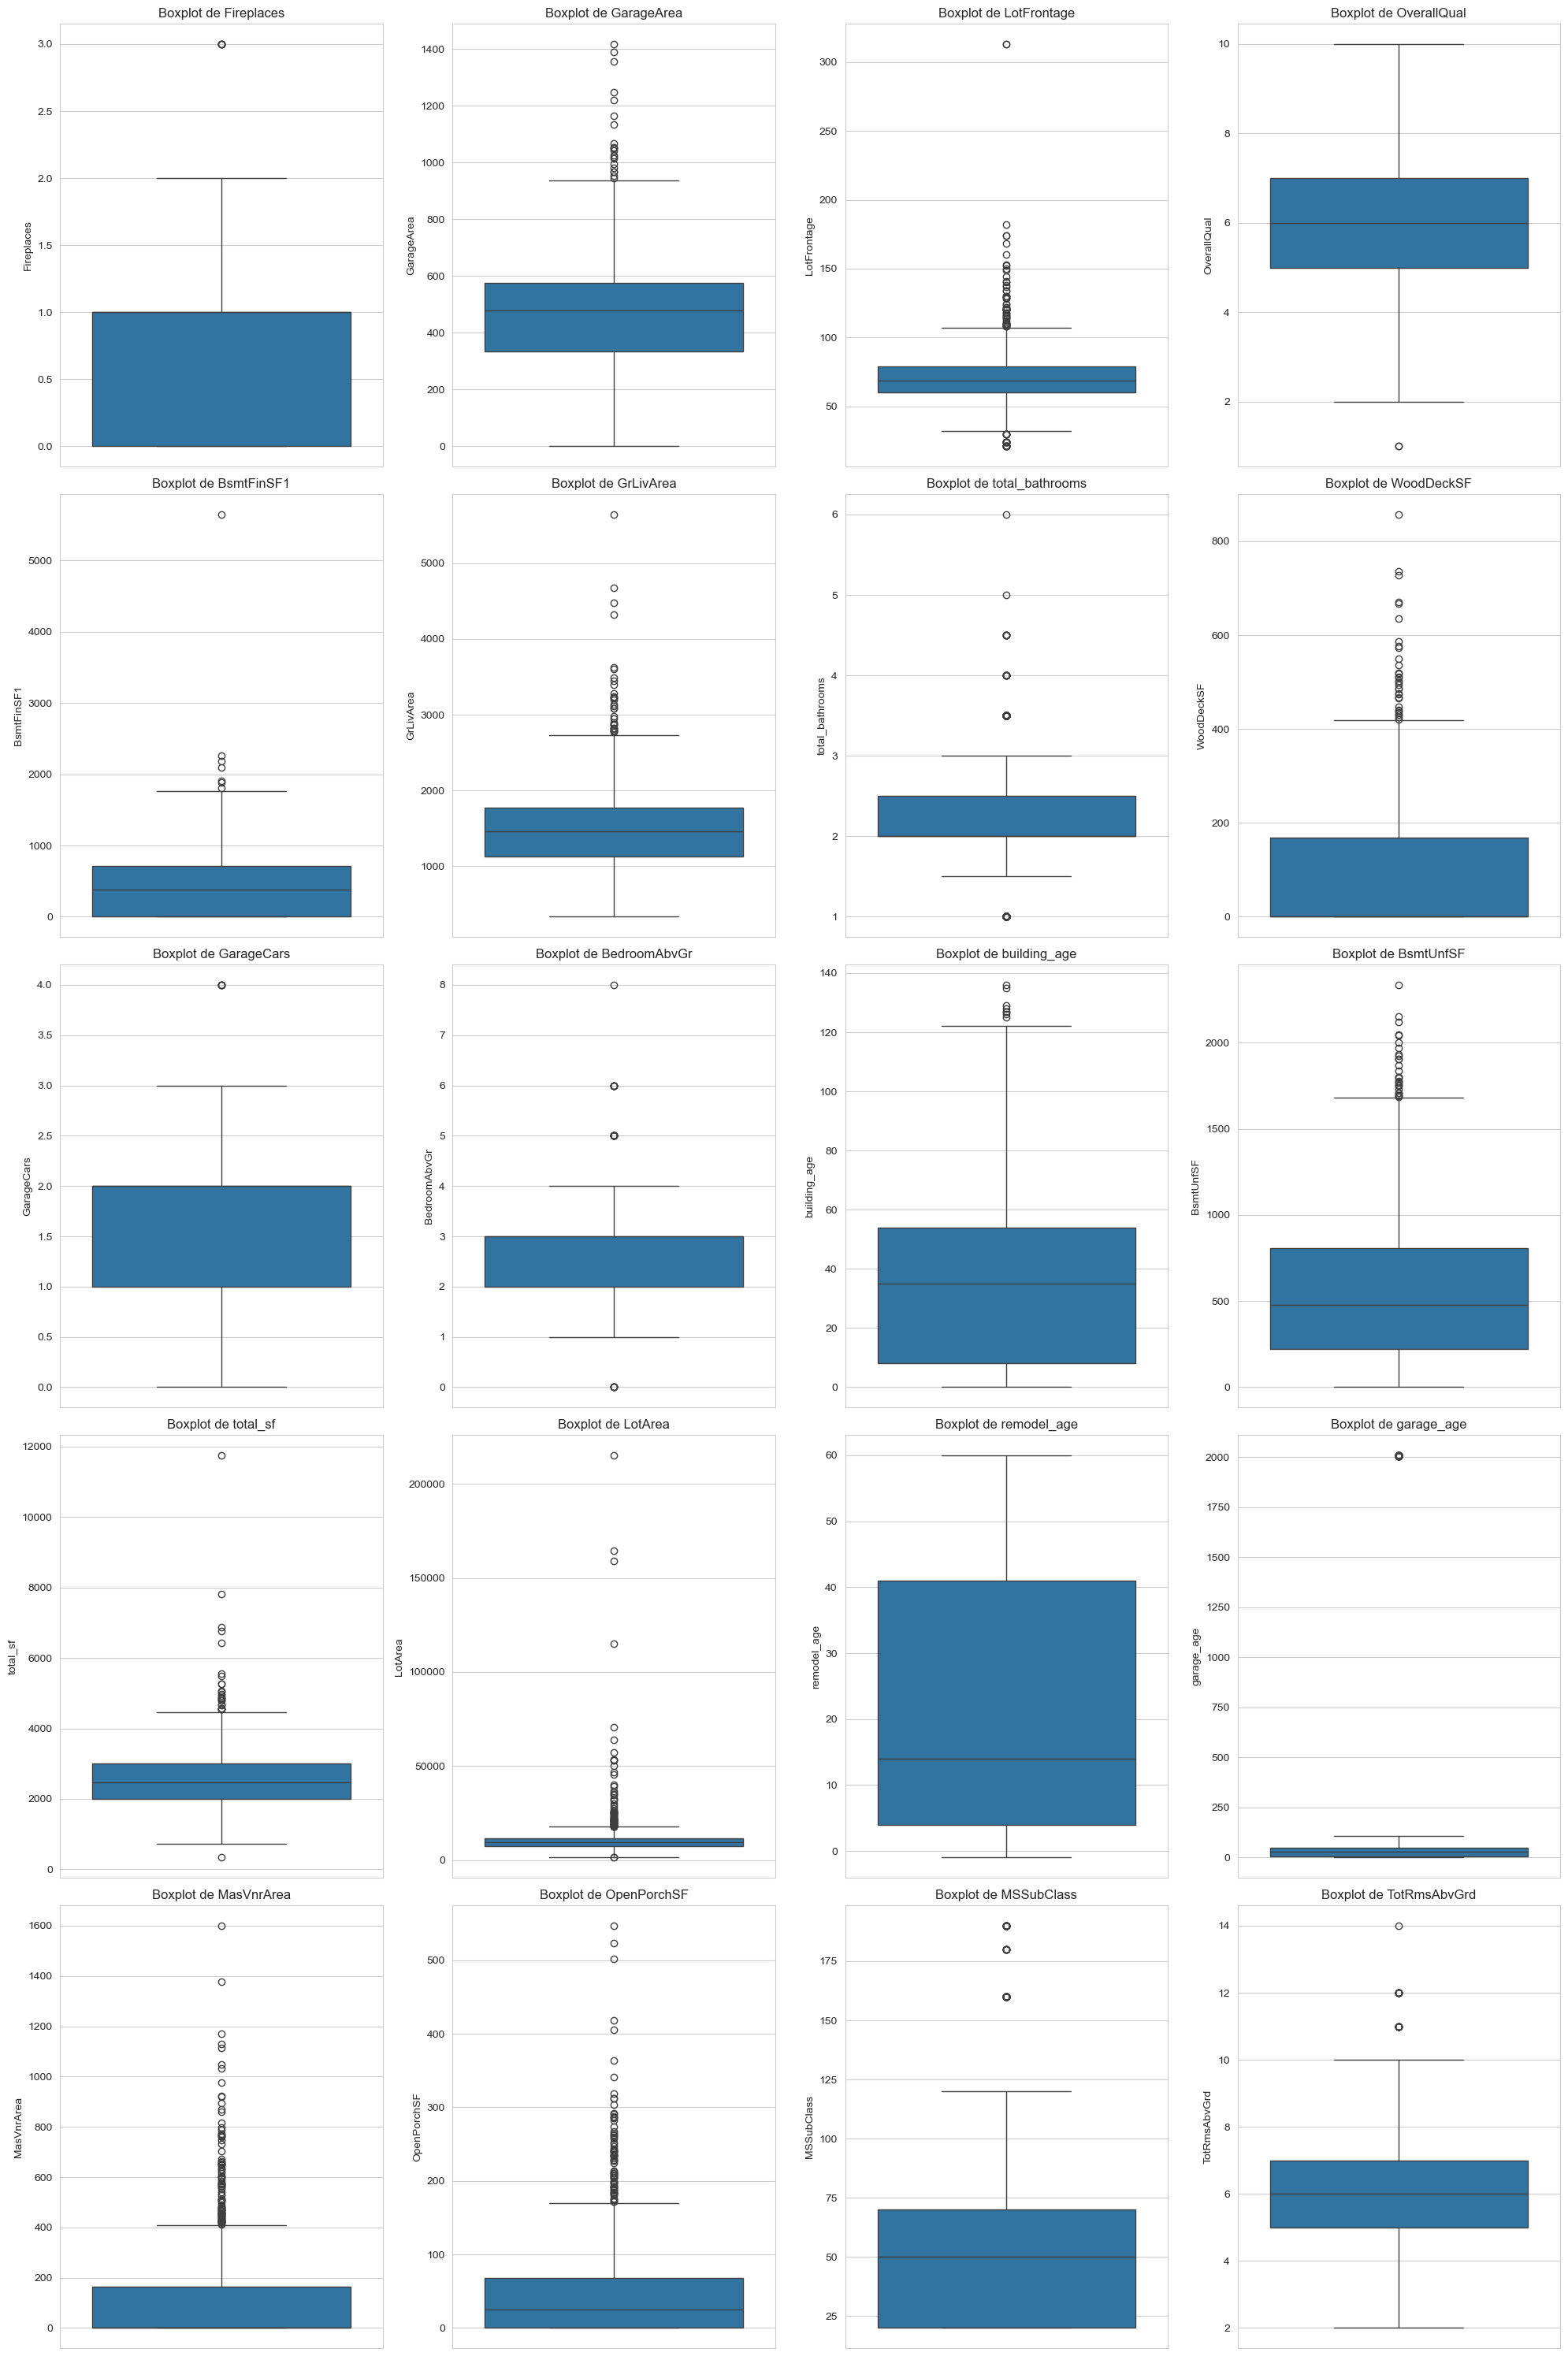

In [40]:
# Visualisation des boxplots
n_cols = 4
n_rows = (len(new_numeric_cols) + n_cols - 1) // n_cols
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(new_numeric_cols):
    sns.boxplot(y=train_filtered[feature], ax=axes[i])
    axes[i].set_title(f"Boxplot de {feature}")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

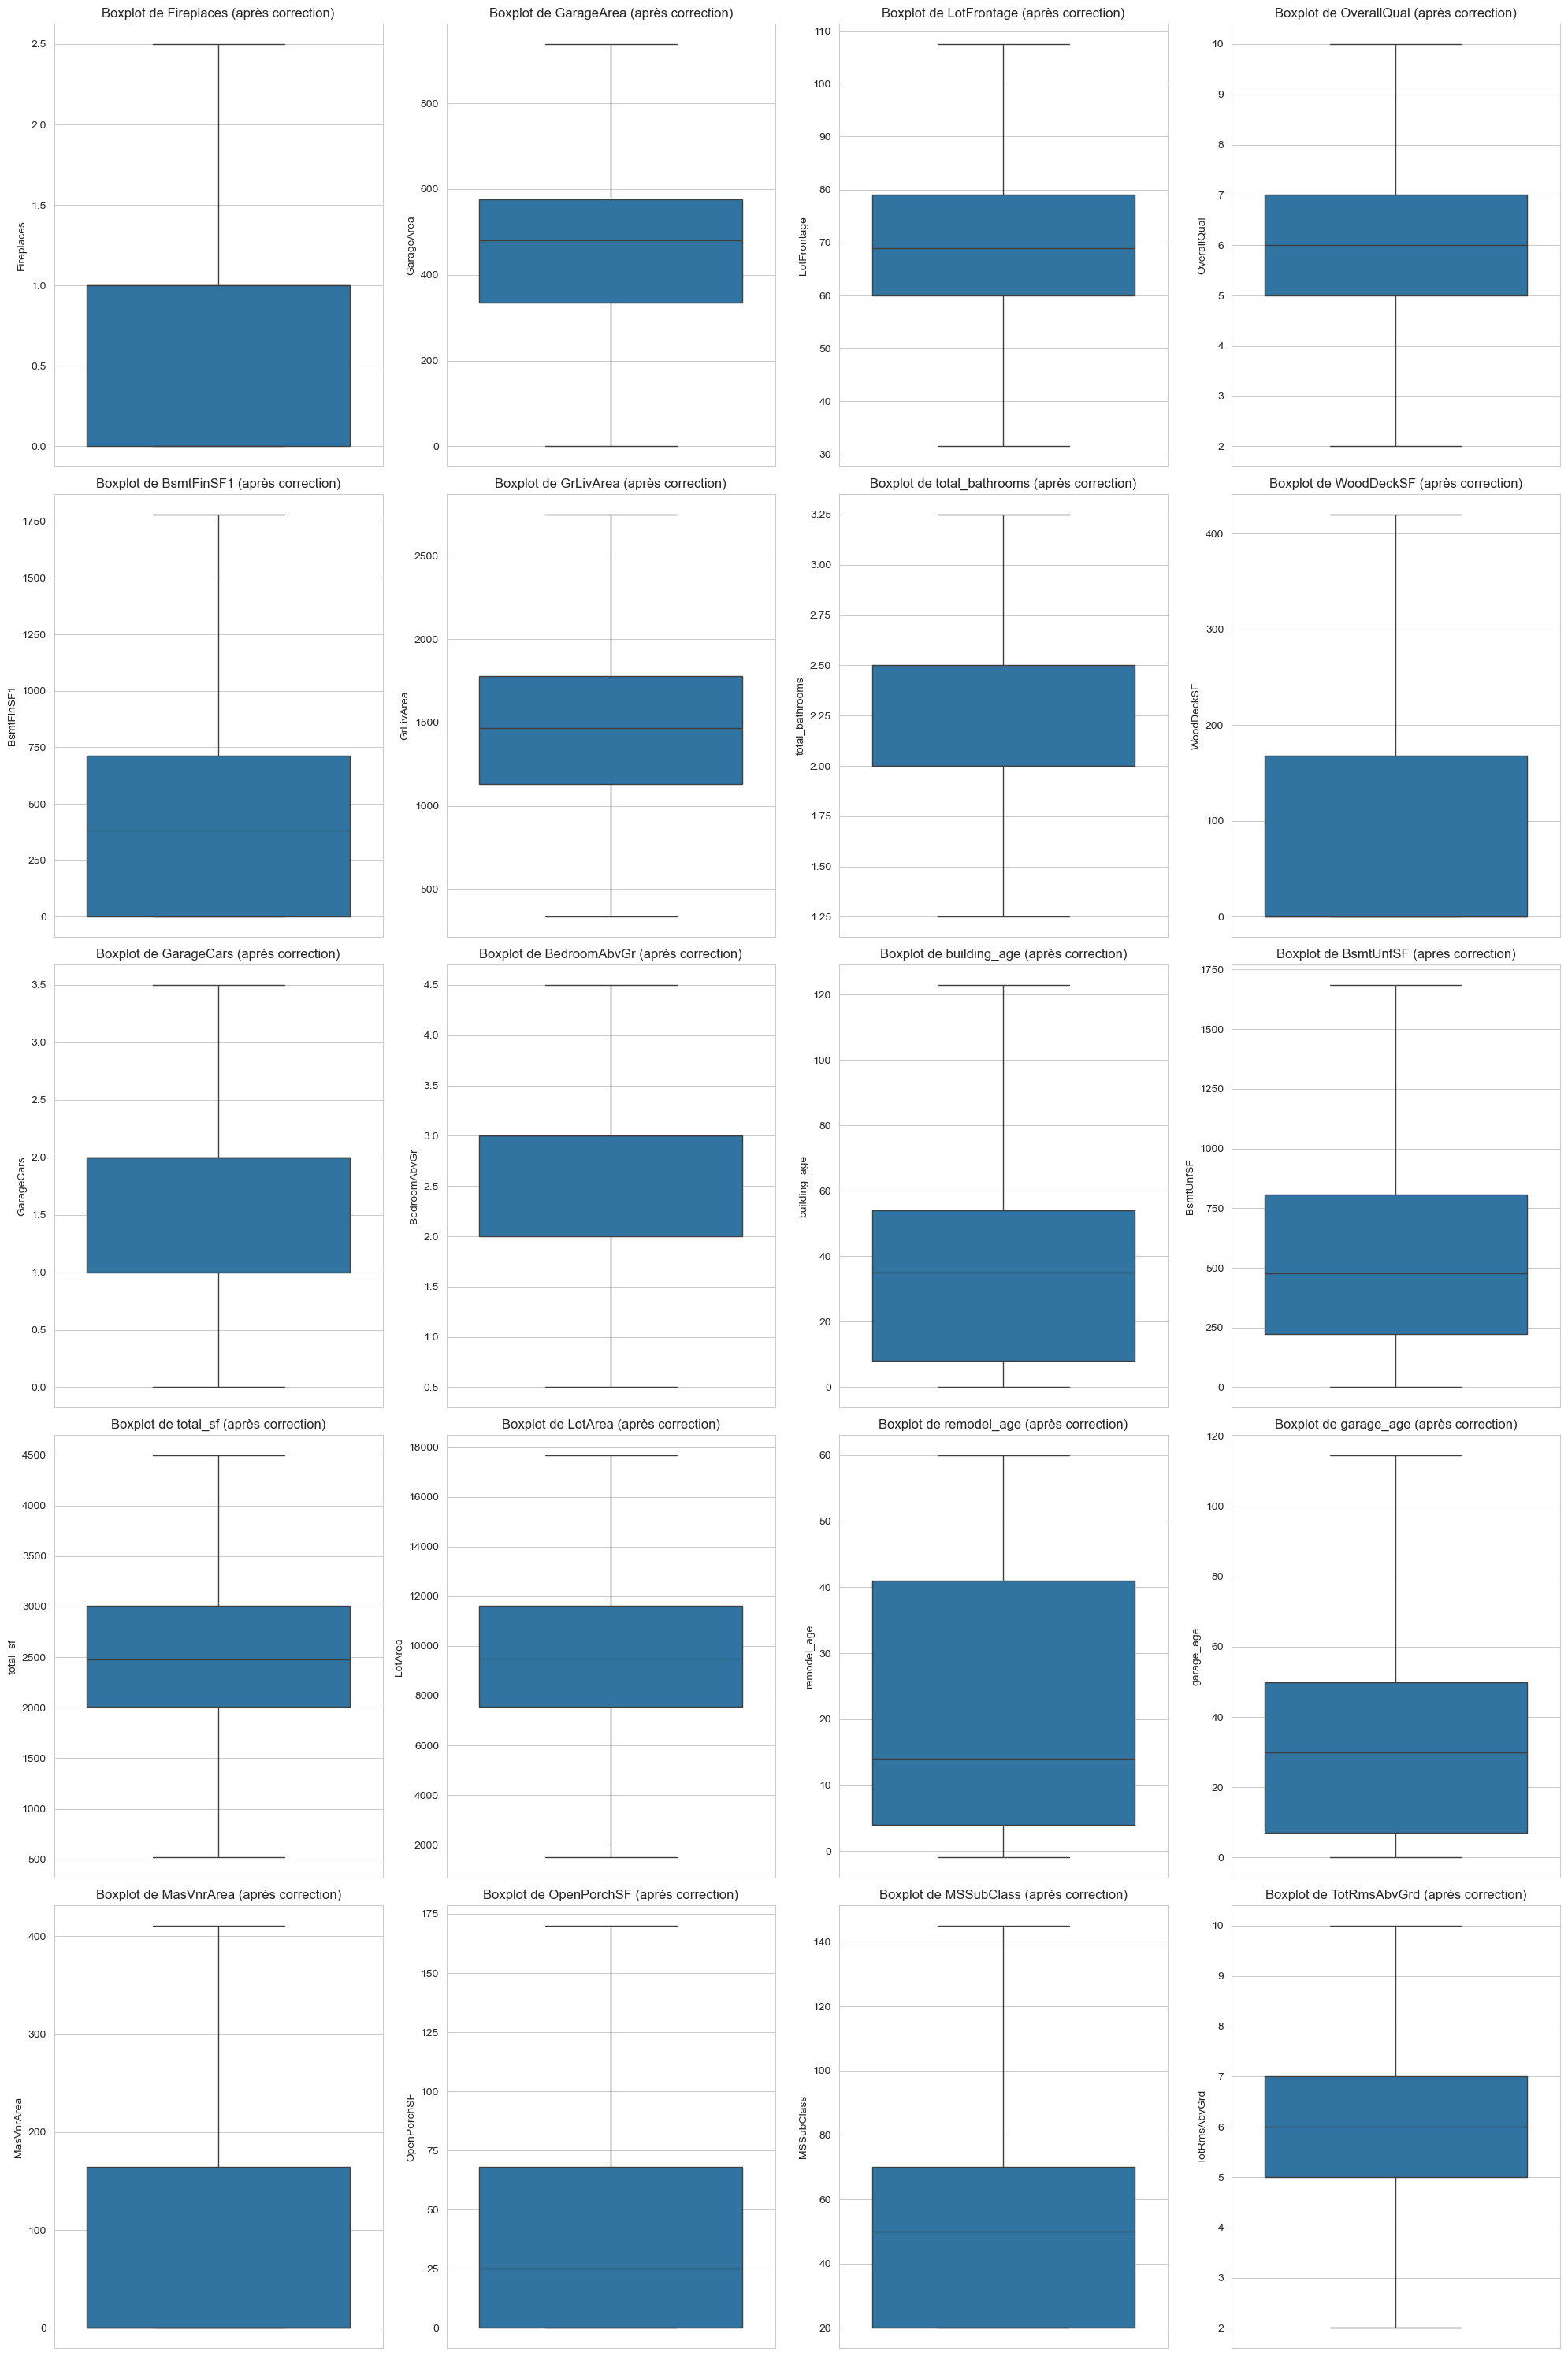

In [41]:
# Correction des outliers
train_filtered = remove_outliers(train_filtered, new_numeric_cols)
test_filtered = remove_outliers(test_filtered, new_numeric_cols)

# Vérification visuelle après correction
fig, axes = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 6 * n_rows))
axes = axes.flatten()

for i, feature in enumerate(new_numeric_cols):
    sns.boxplot(y=train_filtered[feature], ax=axes[i])
    axes[i].set_title(f"Boxplot de {feature} (après correction)")

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Étape 9 : Encodage et standardisation

Objectif : Préparer les données pour la modélisation en encodant les variables catégoriques et en standardisant les numériques.

### Actions
- Utiliser `ColumnTransformer` pour le prétraitement.
- Sauvegarder le preprocessor pour réutilisation.

In [42]:
# Préparation des données
X_train = train_filtered.drop(columns=[TARGET_NAME])
y_train = train_filtered[TARGET_NAME]

# Prétraitement
X_train_processed, X_test_processed, preprocessor = preprocess_data(
    X_train, test_filtered, new_categorical_cols, new_numeric_cols
)

# Sauvegarde du preprocessor
joblib.dump(preprocessor, PROJECT_DIR / "models/preprocessor.joblib")
logger.info("Preprocessor sauvegardé.")

# Vérification des dimensions
logger.info(f"Dimensions de X_train_processed: {X_train_processed.shape}")
logger.info(f"Dimensions de X_test_processed: {X_test_processed.shape}")

2025-07-30 22:01:15,219 - INFO - Preprocessor sauvegardé.
2025-07-30 22:01:15,221 - INFO - Dimensions de X_train_processed: (1460, 75)
2025-07-30 22:01:15,227 - INFO - Dimensions de X_test_processed: (1459, 75)


## Étape 10 : Sauvegarde des données traitées

Objectif : Exporter les données prétraitées pour l’entraînement futur.

### Actions
- Créer le dossier `processed` si nécessaire.
- Sauvegarder les DataFrames en CSV.

In [43]:
# Création du dossier processed

PROCESSED_DIR.mkdir(parents=True, exist_ok=True)

# Conversion en DataFrame
X_train_df = pd.DataFrame(X_train_processed, columns=preprocessor.get_feature_names_out())
X_test_df = pd.DataFrame(X_test_processed, columns=preprocessor.get_feature_names_out())
y_train_df = pd.DataFrame(y_train).reset_index(drop=True)

# Sauvegarde
X_train_df.to_csv(PROCESSED_DIR / "X_train_processed.csv", index=False)
X_test_df.to_csv(PROCESSED_DIR / "X_test_processed.csv", index=False)
y_train_df.to_csv(PROCESSED_DIR / "y_train.csv", index=False)

logger.info("Données prétraitées sauvegardées avec succès.")

2025-07-30 22:01:25,252 - INFO - Données prétraitées sauvegardées avec succès.
